# 1) prepare data:

In [1]:
import pandas as pd
import numpy as np
import torch
import pickle
import argparse

from metrics import (
    calculate_grouped_ndcg_random, 
    calculate_grouped_ndcg_sum_popularity,
    calculate_grouped_ndcg_with_embeddings,
    calculate_grouped_ndcg_for_bert4rec_output
)

In [2]:
rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table('movielens_1m_dataset/ratings.dat', sep='::', header=None, names=rnames, engine='python', encoding='ISO-8859-1')

In [3]:
ratings

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [4]:
ratings.sort_values(["user_id", "timestamp"], inplace=True)

ratings = ratings[["user_id", "movie_id", "rating"]]

ratings.reset_index(drop=True, inplace=True)

ratings = ratings.astype(int)

ratings

,user_id,movie_id,rating
0,1,3186,4
1,1,1270,5
2,1,1721,4
3,1,1022,5
4,1,2340,3
...,...,...,...
1000204,6040,2917,4
1000205,6040,1921,4
1000206,6040,1784,3
1000207,6040,161,3


In [5]:
ratings.user_id.nunique(), ratings.user_id.min(), ratings.user_id.max()

(6040, 1, 6040)

In [6]:
ratings.movie_id.nunique(), ratings.movie_id.min(), ratings.movie_id.max()

(3706, 1, 3952)

In [7]:
# every rated movie (even if its 1) is being considered as implicit positive - he decided to watch this movie
ratings.rating = 1

ratings

,user_id,movie_id,rating
0,1,3186,1
1,1,1270,1
2,1,1721,1
3,1,1022,1
4,1,2340,1
...,...,...,...
1000204,6040,2917,1
1000205,6040,1921,1
1000206,6040,1784,1
1000207,6040,161,1


In [8]:
# to match bert4rec paper's statistics of dataset - we will skip this
# ratings = ratings[ratings.groupby("movie_id")['user_id'].transform('count') >= 5]

ratings.reset_index(drop=True, inplace=True)

ratings

,user_id,movie_id,rating
0,1,3186,1
1,1,1270,1
2,1,1721,1
3,1,1022,1
4,1,2340,1
...,...,...,...
1000204,6040,2917,1
1000205,6040,1921,1
1000206,6040,1784,1
1000207,6040,161,1


In [9]:
print("statistics:", ratings.user_id.nunique(), ratings.movie_id.nunique())

statistics: 6040 3706


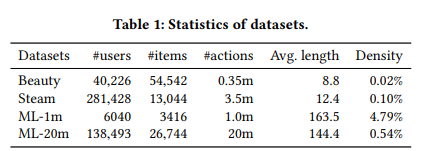

In [10]:
def create_index_mapping(df):
    u2ix = {user_id: i for i, user_id in enumerate(df.user_id.unique())}
    i2ix = {item_id: i for i, item_id in enumerate(df.movie_id.unique())}
    return u2ix, i2ix

def apply_index_mapping(df, u2ix, i2ix):
    df.user_id = df.user_id.map(lambda x: u2ix[x])
    df.movie_id = df.movie_id.map(lambda x: i2ix[x])
    return df

u2ix, i2ix = create_index_mapping(ratings)
ratings = apply_index_mapping(ratings, u2ix, i2ix)

In [11]:
ratings.user_id.min(), ratings.user_id.max()

(0, 6039)

In [12]:
ratings.movie_id.min(), ratings.movie_id.max()

(0, 3705)

leave-last-out:

In [13]:
test = ratings.groupby("user_id").tail(1)

test

,user_id,movie_id,rating
52,0,52,1
181,1,174,1
232,2,207,1
253,3,88,1
451,4,384,1
...,...,...,...
999522,6035,927,1
999724,6036,684,1
999744,6037,1587,1
999867,6038,579,1


In [14]:
train_and_val = ratings.drop(test.index, axis=0)

train_and_val

,user_id,movie_id,rating
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
...,...,...,...
1000203,6039,1097,1
1000204,6039,1248,1
1000205,6039,370,1
1000206,6039,89,1


In [15]:
val = train_and_val.groupby("user_id").tail(1)

val

,user_id,movie_id,rating
51,0,51,1
180,1,173,1
231,2,206,1
252,3,217,1
450,4,383,1
...,...,...,...
999521,6035,3356,1
999723,6036,244,1
999743,6037,252,1
999866,6038,562,1


In [16]:
train = train_and_val.drop(val.index, axis=0)

train

,user_id,movie_id,rating
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
...,...,...,...
1000202,6039,180,1
1000203,6039,1097,1
1000204,6039,1248,1
1000205,6039,370,1


In [17]:
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# we need this only for baselines and als - we dont use validation holdout in these, only test
train_and_val.reset_index(drop=True, inplace=True)

In [18]:
train_dict = dict(train.groupby('user_id').apply(lambda d: list(d['movie_id'])))
val_dict = dict(val.groupby('user_id').apply(lambda d: list(d['movie_id'])))
test_dict = dict(test.groupby('user_id').apply(lambda d: list(d['movie_id'])))

In [19]:
# we will need this data in this format later in bert4rec
dataset_for_bert4rec = {'train': train_dict,
                       'val': val_dict,
                       'test': test_dict,
                       'umap': u2ix,
                       'smap': i2ix}

In [20]:
import pickle

with open('prepared_dataset/dataset_for_bert4rec.pickle', 'wb') as handle:
    pickle.dump(dataset_for_bert4rec, handle, protocol=pickle.HIGHEST_PROTOCOL)

##### sample negative examples for each user (popularity sampling strategy):

In [21]:
user_positively_interacted_with = ratings.groupby('user_id')['movie_id'].apply(set).to_dict()

In [22]:
assert len(user_positively_interacted_with[1]) == len(train_and_val[train_and_val.user_id == 1]) + 1

In [23]:
item_count = ratings["movie_id"].value_counts().to_dict()
item_probabilities = {k: v / sum([x for x in item_count.values()]) for k, v in item_count.items()}

In [24]:
import numpy as np
from numpy.random import choice

negative_samples = dict()
test_rows = []

for _, row in test.iterrows():
    test_interactions = [(row["user_id"], row["movie_id"], row["rating"],)]
    
    np.random.seed(row["user_id"])
    negative_sampled_interactions = list(choice(list(item_probabilities.keys()), 800, replace=False, p=list(item_probabilities.values())))
    negative_sampled_interactions = [x for x in negative_sampled_interactions if x not in user_positively_interacted_with[row["user_id"]]]
    negative_sampled_interactions = negative_sampled_interactions[:100]
    
    # we will use this negative_samples in bert4rec:
    negative_samples[row["user_id"]] = negative_sampled_interactions

    test_interactions.extend([(row["user_id"], x, 0,) for x in negative_sampled_interactions])
    
    test_rows.extend(test_interactions)
    
test_rows[:10]

[(0, 52, 1),
 (0, 1068, 0),
 (0, 731, 0),
 (0, 1026, 0),
 (0, 314, 0),
 (0, 1148, 0),
 (0, 1008, 0),
 (0, 1030, 0),
 (0, 1513, 0),
 (0, 2575, 0)]

In [25]:
negative_samples[0][:9]

[1068, 731, 1026, 314, 1148, 1008, 1030, 1513, 2575]

In [26]:
neg_sampled_test = pd.DataFrame(test_rows, columns=["user_id", "movie_id", "rating"])

neg_sampled_test

,user_id,movie_id,rating
0,0,52,1
1,0,1068,0
2,0,731,0
3,0,1026,0
4,0,314,0
...,...,...,...
610035,6039,442,0
610036,6039,581,0
610037,6039,147,0
610038,6039,1327,0


# 2) run baselines:

##### random baseline:

In [27]:
ndcgresults = []
for i in range(10):
    ndcg_value = calculate_grouped_ndcg_random(train_and_val, neg_sampled_test, 10, i)
    
    ndcgresults.append(ndcg_value)
    
np.mean(ndcgresults), np.std(ndcgresults)

(0.04383581806122516, 0.0015566100955503503)

##### pop baseline:

In [28]:
calculate_grouped_ndcg_sum_popularity(train_and_val, neg_sampled_test, 10)

0.0637115264389976

##### iALS and BPR baselines:

In [29]:
import scipy.sparse as sparse

def create_sparse_matrix(df):
    csr = sparse.csr_matrix((df.rating, (df.user_id, df.movie_id)))
    return csr

sparse_train_and_val = create_sparse_matrix(train_and_val)

In [30]:
import implicit

In [31]:
iALS = implicit.als.AlternatingLeastSquares(factors=256, iterations=150)

C:\Users\atama\anaconda3\envs\conda_bert4rec\lib\site-packages\implicit\cpu\als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


In [32]:
iALS.fit(sparse_train_and_val)

  0%|          | 0/150 [00:00<?, ?it/s]

In [33]:
calculate_grouped_ndcg_with_embeddings(neg_sampled_test, iALS, 10)

0.22219820326153908

In [34]:
BPRMF = implicit.bpr.BayesianPersonalizedRanking(factors=256, iterations=150)

In [35]:
BPRMF.fit(sparse_train_and_val)

  0%|          | 0/150 [00:00<?, ?it/s]

In [36]:
calculate_grouped_ndcg_with_embeddings(neg_sampled_test, BPRMF, 10)

0.2720362446001705

# 3) prepare datasets and dataloaders for bert4rec:

In [27]:
# for using argparse in ipython
import sys
sys.argv = ['']

In [28]:
from bert4rec_modules_and_configs.utils import *
from bert4rec_modules_and_configs.options import args

In [29]:
# load from data preparation step
def read_data(prepared_data_path):
    with open(prepared_data_path, 'rb') as handle:
        dataset = pickle.load(handle)
    return dataset

In [30]:
data = read_data(args.prepared_data_path)

train_data = data['train']
val_data = data['val']
test_data = data['test']
umap = data['umap']
smap = data['smap']

In [31]:
# track user ix 0 (original user id 1)
print(train_data[0])
print(val_data[0])
print(test_data[0])
print(umap[1])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
[51]
[52]
0


prepare train dataset and dataloader:

In [32]:
class BertTrainDataset(torch.utils.data.Dataset):
    def __init__(self, u2seq, max_len, mask_prob, mask_token, num_items, rng):
        self.u2seq = u2seq
        self.users = sorted(self.u2seq.keys())
        self.max_len = max_len
        self.mask_prob = mask_prob
        self.mask_token = mask_token
        self.num_items = num_items
        self.rng = rng

    def __len__(self):
        return len(self.users)

    def __getitem__(self, index):
        user = self.users[index]
        seq = self._getseq(user)

        tokens = []
        labels = []
        for s in seq:
            prob = self.rng.random()
            if prob < self.mask_prob:
                prob /= self.mask_prob

                # 1. some strange logic here:
                if prob < 0.8:
                    tokens.append(self.mask_token) # this is okay
                elif prob < 0.9:
                    tokens.append(self.rng.randint(1, self.num_items)) # this is weird
                else:
                    tokens.append(s)  # this is weird

                labels.append(s) # 2. if s == 0 and it's masked, then we won't make backprop for this one
            else:
                tokens.append(s)
                labels.append(0)

        tokens = tokens[-self.max_len:]
        labels = labels[-self.max_len:]

        mask_len = self.max_len - len(tokens)

        # 3. padding token (0) is the same as item token (s == 0).
        tokens = [0] * mask_len + tokens
        labels = [0] * mask_len + labels

        # example of output:
        # tokens    0   0   0   2969, 1574,   957,    1178,   <3707>, 1658,   <3707>, 1117, ...
        # labels    0   0   0   0     0       0       0       2147    0       3177    0     ...
        return torch.LongTensor(tokens), torch.LongTensor(labels)
        
    def _getseq(self, user):
        return self.u2seq[user]

In [33]:
train_torch_dataset = BertTrainDataset(
    u2seq=      train_data,
    max_len=    args.bert_max_len,
    mask_prob=  args.bert_mask_prob,
    mask_token= len(smap) + 1,
    num_items=  len(smap),
    rng=        random.Random(args.dataloader_random_seed)
)

In [34]:
# track user ix 0 (original user id 1)
print(train_torch_dataset[0])

(tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
          11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
          23,   24, 3707,   26,   27,   28,   29,   30,   31,   32,   33,   34,
        3707,   36,   37,   38,   39, 3707,   41,   42,   43,   44,   45,   46,
          47,   48,   49,   50]), tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
     

In [35]:
train_torch_dataloader = torch.utils.data.DataLoader(
    dataset=train_torch_dataset,
    batch_size=args.train_batch_size,
    shuffle=True,
    pin_memory=True
)

prepare val and test dataset and dataloader:

In [36]:
# popularity = Counter()
# for user in range(len(umap)):
#     popularity.update(train_data[user])
#     popularity.update(val_data[user])
#     popularity.update(test_data[user])
# item_probabilities = {k: v / sum([x for x in popularity.values()]) for k, v in popularity.items()}

# print("PROB CHECK")
# print(item_probabilities[62])
# print(item_probabilities[731])

# negative_samples = {}
# print('Sampling negative items')
# for user in trange(len(umap)):
#     seen = set(train_data[user])
#     seen.update(val_data[user])
#     seen.update(test_data[user])

#     np.random.seed(user)

#     negative_sampled_interactions = list(choice(list(item_probabilities.keys()), 800, replace=False, p=list(item_probabilities.values())))
#     negative_sampled_interactions = [x for x in negative_sampled_interactions if x not in seen]
#     negative_sampled_interactions = negative_sampled_interactions[:100]

#     negative_samples[user] = negative_sampled_interactions

take negative_samples from data preparation step

In [37]:
# track user ix 0 (original user id 1)
print(negative_samples[0])

[1068, 731, 1026, 314, 1148, 1008, 1030, 1513, 2575, 388, 398, 525, 1438, 1682, 215, 258, 129, 2122, 1954, 1869, 2824, 859, 748, 983, 183, 1436, 233, 1803, 1182, 874, 1305, 2056, 752, 844, 971, 1065, 671, 2549, 2153, 325, 981, 1766, 60, 880, 1028, 557, 144, 948, 1302, 3160, 743, 424, 796, 947, 180, 1191, 458, 534, 386, 1110, 622, 208, 592, 2055, 739, 1215, 2751, 489, 2863, 502, 1095, 73, 138, 580, 522, 443, 699, 125, 653, 390, 832, 193, 1906, 284, 663, 147, 1022, 241, 597, 1294, 1776, 1688, 809, 1260, 1529, 738, 652, 631, 665, 203]


In [38]:
class BertEvalDataset(torch.utils.data.Dataset):
    def __init__(self, u2seq, u2answer, max_len, mask_token, negative_samples):
        self.u2seq = u2seq
        self.users = sorted(self.u2seq.keys())
        self.u2answer = u2answer
        self.max_len = max_len
        self.mask_token = mask_token
        self.negative_samples = negative_samples

    def __len__(self):
        return len(self.users)

    def __getitem__(self, index):
        user = self.users[index]
        seq = self.u2seq[user]
        answer = self.u2answer[user]
        negs = self.negative_samples[user]

        candidates = answer + negs
        labels = [1] * len(answer) + [0] * len(negs)

        seq = seq + [self.mask_token]

        # same as in BertTrainDataset
        seq = seq[-self.max_len:]
        padding_len = self.max_len - len(seq)
        seq = [0] * padding_len + seq

        return torch.LongTensor(seq), torch.LongTensor(candidates), torch.LongTensor(labels)
        # example as in BertTrainDataset:
        # seq (just like tokens in train):  0   0   2969,   1574,   957,    1178,   2147,   1658,   3177,   1117, <3707>
        #
        # candidates: [ix of real positive item; sampled negatives]
        # labels:     [1, 0, 0, 0, 0, ...]

In [39]:
val_torch_dataset = BertEvalDataset(
    u2seq=              train_data,
    u2answer=           val_data,
    max_len=            args.bert_max_len,
    mask_token=         len(smap) + 1,
    negative_samples=   negative_samples
)

In [40]:
# track user ix 0 (original user id 1)
print(val_torch_dataset[0])

(tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
          12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,   23,
          24,   25,   26,   27,   28,   29,   30,   31,   32,   33,   34,   35,
          36,   37,   38,   39,   40,   41,   42,   43,   44,   45,   46,   47,
          48,   49,   50, 3707]), tensor([  51, 1068,  731, 1026,  314, 1148, 1008, 1030, 1513, 2575,  388,  398,
         525, 1438, 1682,  215,  258,  129, 2122, 1954, 1869, 2824,  859,  748,
         983,  183, 1436,  233, 1803, 1182,  874, 1305, 2056,  752,  844,  971,
        1065,  671, 2549, 2153,  325,  981, 1766,   60,  880, 1028,  557,  144,
     

In [41]:
val_torch_dataloader = torch.utils.data.DataLoader(val_torch_dataset, batch_size=args.val_batch_size,
                                       shuffle=False, pin_memory=True)

In [42]:
test_torch_dataset = BertEvalDataset(
        u2seq=              train_data,
        u2answer=           test_data,
        max_len=            args.bert_max_len,
        mask_token=         len(smap) + 1,
        negative_samples=   negative_samples
    )

In [43]:
# track user ix 0 (original user id 1)
print(test_torch_dataset[0])

(tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
          12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,   23,
          24,   25,   26,   27,   28,   29,   30,   31,   32,   33,   34,   35,
          36,   37,   38,   39,   40,   41,   42,   43,   44,   45,   46,   47,
          48,   49,   50, 3707]), tensor([  52, 1068,  731, 1026,  314, 1148, 1008, 1030, 1513, 2575,  388,  398,
         525, 1438, 1682,  215,  258,  129, 2122, 1954, 1869, 2824,  859,  748,
         983,  183, 1436,  233, 1803, 1182,  874, 1305, 2056,  752,  844,  971,
        1065,  671, 2549, 2153,  325,  981, 1766,   60,  880, 1028,  557,  144,
     

In [44]:
test_torch_dataloader = torch.utils.data.DataLoader(test_torch_dataset, batch_size=args.test_batch_size,
                                                       shuffle=False, pin_memory=True)

# 4) describe model:

In [46]:
from torch import nn as nn

from bert4rec_modules_and_configs.models.bert_modules.embedding import BERTEmbedding
from bert4rec_modules_and_configs.models.bert_modules.transformer import TransformerBlock


class BERT(nn.Module):
    def __init__(self, args):
        super().__init__()

        fix_random_seed_as(args.model_init_seed)
        # self.init_weights()

        max_len = args.bert_max_len
        num_items = args.num_items
        n_layers = args.bert_num_blocks
        heads = args.bert_num_heads
        vocab_size = num_items + 2
        hidden = args.bert_hidden_units
        self.hidden = hidden
        dropout = args.bert_dropout

        # embedding for BERT: token emb + positional emb
        self.embedding = BERTEmbedding(vocab_size=vocab_size, embed_size=self.hidden, max_len=max_len, dropout=dropout)

        # multi-layers transformer blocks, deep network
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(hidden, heads, hidden * 4, dropout) for _ in range(n_layers)])

    def forward(self, x):
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)

        # embedding the indexed sequence to sequence of vectors
        x = self.embedding(x)
        
        # running over multiple transformer blocks
        for transformer in self.transformer_blocks:
            x = transformer.forward(x, mask)

        return x

    def init_weights(self):
        pass

In [47]:
class BERTModel(nn.Module):
    def __init__(self, args):
        super().__init__()
        
        self.args = args
        
        self.bert = BERT(args)
        self.out = nn.Linear(self.bert.hidden, args.num_items + 1)

    def code(cls):
        return 'bert'

    def forward(self, x):
        x = self.bert(x)
        return self.out(x)

In [48]:
args.num_items = len(smap)

In [49]:
model = BERTModel(args)

In [50]:
# take some batch (only sequence, dont need labels until train) and pass it through bert4rec:
some_batch = next(iter(train_torch_dataloader))
seq, _ = some_batch

model(seq).shape

torch.Size([128, 100, 3707])

# 5) explanation of every single step in bert4rec:

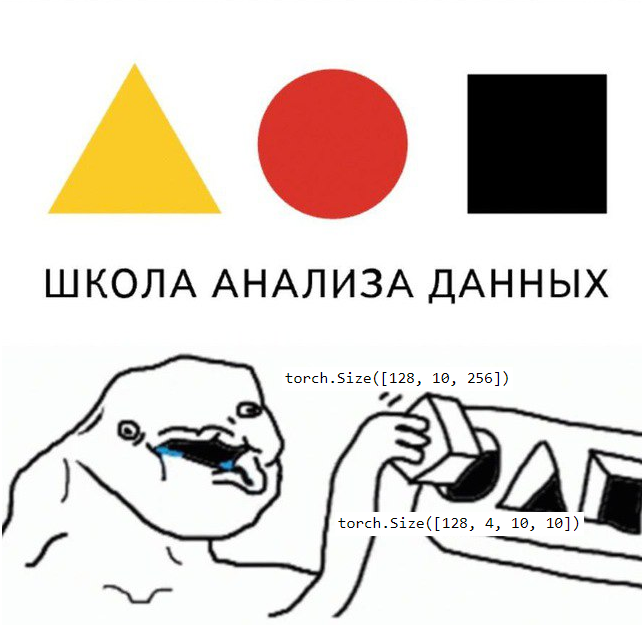

##### 1) input:

In [120]:
# looking for some good batch with easy-to-track user sequence
while True:
    some_batch = next(iter(train_torch_dataloader))
    seq, _ = some_batch # dont need labels until train

    seq = seq[:, :10] # for simplicity of tracking - lets make every sequence of len 10 instead of 100
    
    len_of_padding = (seq[0] == 0).sum()
    num_of_mask_tokens = (seq[0] == 3707).sum()
    
    if (2 <= len_of_padding <= 6) and (num_of_mask_tokens == 2): # first user sequence has some padding and some mask tokens:
        break

In [145]:
print(seq.shape)
print("look at first user:")
print(seq[0])

torch.Size([128, 10])
look at first user:
tensor([   0,    0,    0,    0, 1556,  552,  595, 3707,  267, 3707])


##### 2) mask (we will need it later in attention part):

In [146]:
mask = (seq > 0).unsqueeze(1).repeat(1, seq.size(1), 1).unsqueeze(1)

print(mask.shape)
print("look at mask for first user:")
print(mask[0])

torch.Size([128, 1, 10, 10])
look at mask for first user:
tensor([[[False, False, False, False,  True,  True,  True,  True,  True,  True],
         [False, False, False, False,  True,  True,  True,  True,  True,  True],
         [False, False, False, False,  True,  True,  True,  True,  True,  True],
         [False, False, False, False,  True,  True,  True,  True,  True,  True],
         [False, False, False, False,  True,  True,  True,  True,  True,  True],
         [False, False, False, False,  True,  True,  True,  True,  True,  True],
         [False, False, False, False,  True,  True,  True,  True,  True,  True],
         [False, False, False, False,  True,  True,  True,  True,  True,  True],
         [False, False, False, False,  True,  True,  True,  True,  True,  True],
         [False, False, False, False,  True,  True,  True,  True,  True,  True]]])


##### 3) beginning of network, first embedding (tok emb + pos emb):

In [147]:
# reinitialize model with another sequence len for this step-by-step explanation. we will return it back to 100 for train
args.bert_max_len = 10

model = BERTModel(args)

In [149]:
tok_pos_emb = model.bert.embedding(seq)

print(tok_pos_emb.shape)

torch.Size([128, 10, 256])


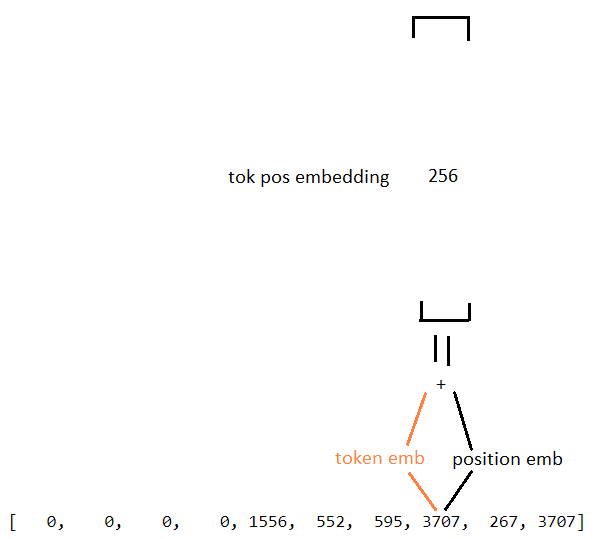

#### going inside TransformerBlock (inside .bert4rec_modules_and_configs/models/bert_modules/transformer.py):

In [150]:
tfblock0 = model.bert.transformer_blocks[0]

##### 4) going through this part:

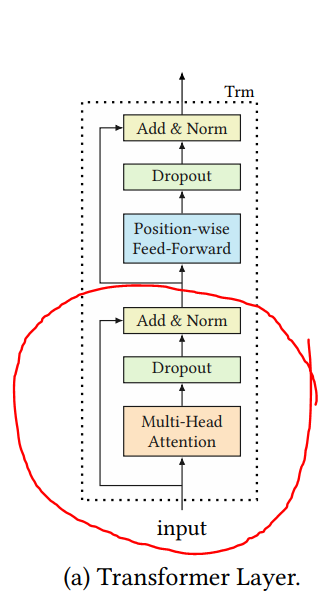

In [151]:
skip_connection = tok_pos_emb

##### 4.1) normalization per layer:

(Batch normalization normalizes each feature independently across the mini-batch. Layer normalization normalizes each of the inputs in the batch independently across all features.)

In [152]:
tok_pos_emb_normalized = tfblock0.layernorm1(tok_pos_emb)

print(tok_pos_emb_normalized.shape)

torch.Size([128, 10, 256])


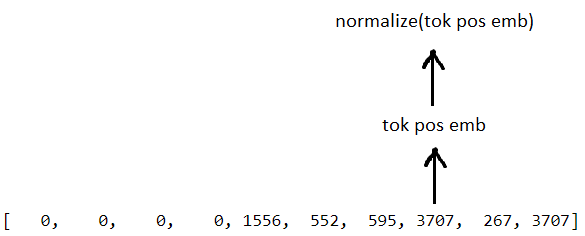

##### 4.2) Multi-Head Attention (inside .bert4rec_modules_and_configs/models/bert_modules/attention/multi_head.py):

In [153]:
batch_size = tok_pos_emb_normalized.size(0) # 128
sequence_len = tok_pos_emb_normalized.size(1) # 10

##### 4.2.1) making Q, K, V matrices:

illustration from [lena voita's lesson for attention](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html):

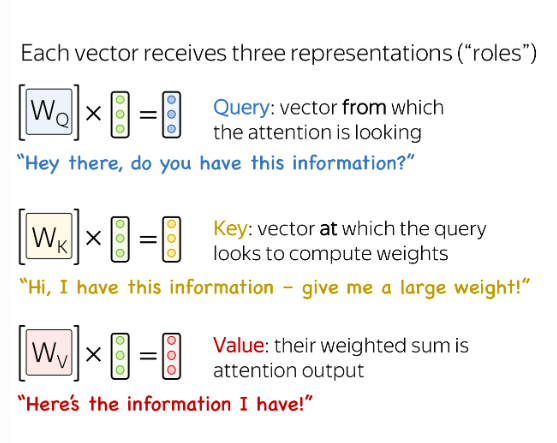

In [154]:
# q = emb * Wq:
Wq = tfblock0.multiheadedattention.linear_layers[0]

Q = Wq(tok_pos_emb_normalized)

print(Q.shape)

torch.Size([128, 10, 256])


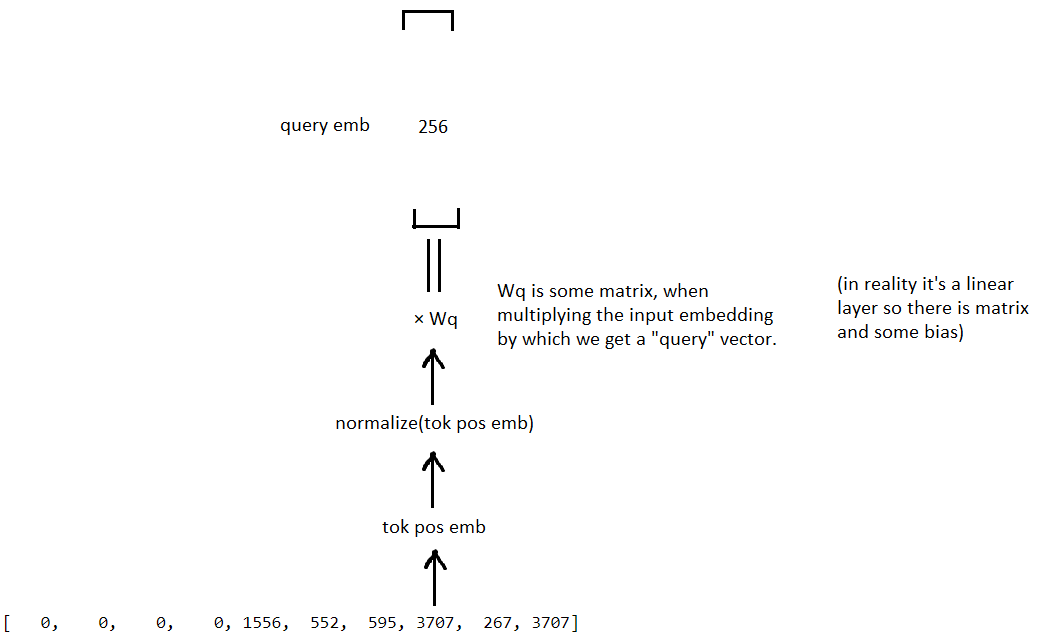

In [155]:
Q_each_head = Q.view(
    batch_size, # keep first dim (batch size, 128)
    sequence_len, # keep second dim (sequence len, 10)
    tfblock0.multiheadedattention.h, # slice embedding dimension 256 into "number of heads" dimension 4...
    tfblock0.multiheadedattention.d_k # ...and "embedding inside head" dimension 64
)

print(Q_each_head.shape)

torch.Size([128, 10, 4, 64])


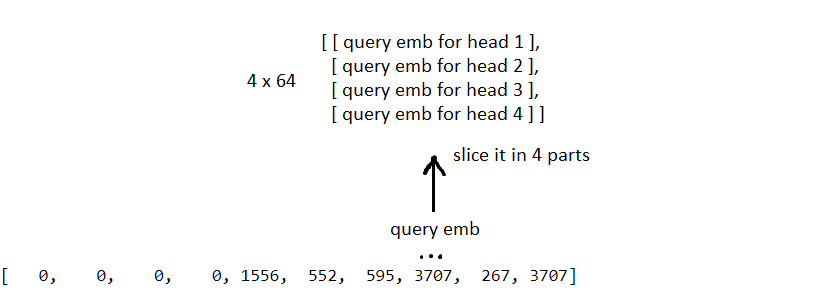

In [156]:
# move "heads" dimension outside of user sequence dimension
Q_each_head = Q_each_head.transpose(1, 2)

print(Q_each_head.shape)

torch.Size([128, 4, 10, 64])


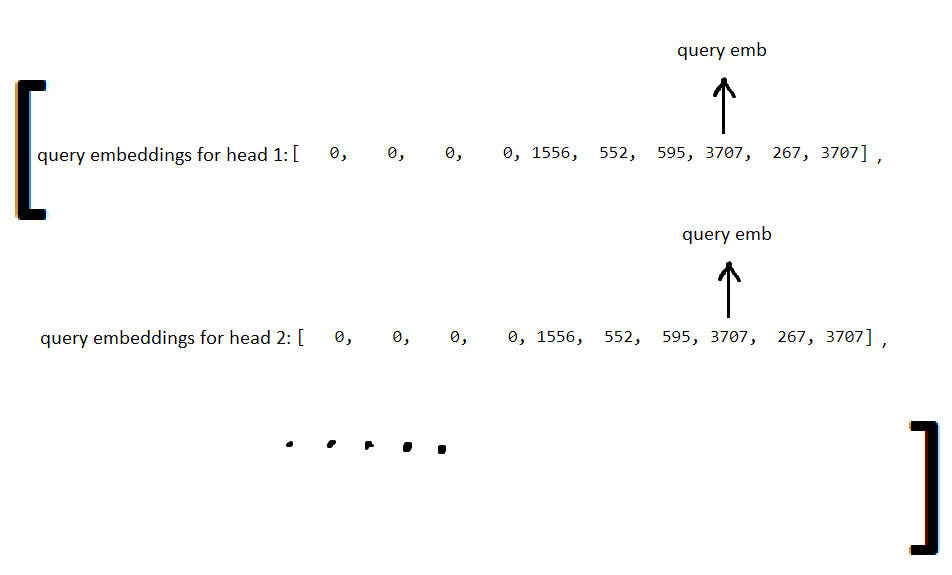

In [157]:
# repeat same for "key" embeddings:
Wk = tfblock0.multiheadedattention.linear_layers[1]

K = Wk(tok_pos_emb_normalized)

K_each_head = K.view(
    batch_size,
    sequence_len,
    tfblock0.multiheadedattention.h,
    tfblock0.multiheadedattention.d_k
)

K_each_head = K_each_head.transpose(1, 2)

print(K_each_head.shape)

torch.Size([128, 4, 10, 64])


In [158]:
# repeat same for "value" embeddings:
Wv = tfblock0.multiheadedattention.linear_layers[2]

V = Wv(tok_pos_emb_normalized)

V_each_head = V.view(
    batch_size,
    sequence_len,
    tfblock0.multiheadedattention.h,
    tfblock0.multiheadedattention.d_k
)

V_each_head = V_each_head.transpose(1, 2)

print(V_each_head.shape)

torch.Size([128, 4, 10, 64])


In [159]:
print(Q_each_head.shape, K_each_head.shape, V_each_head.shape)

torch.Size([128, 4, 10, 64]) torch.Size([128, 4, 10, 64]) torch.Size([128, 4, 10, 64])


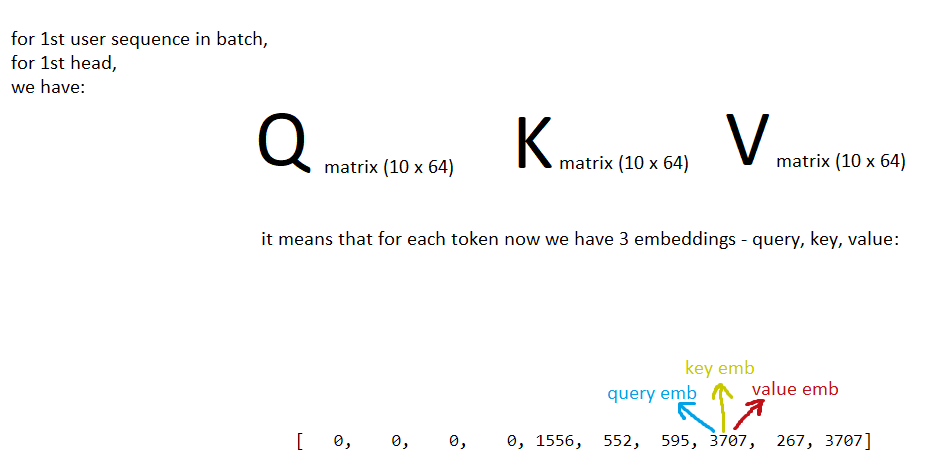

##### 4.2.2) applying self-attention:

illustration from [lena voita's lesson for attention](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html):

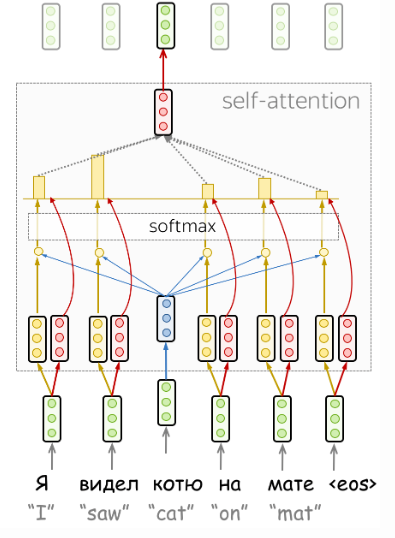

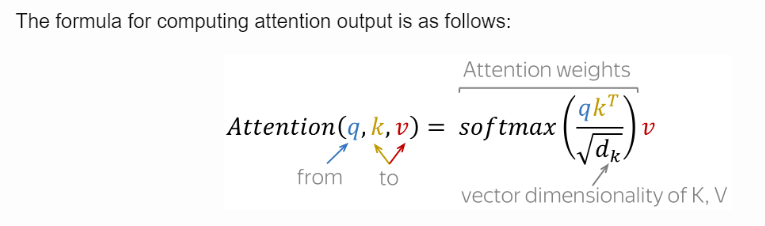

In [167]:
# it's just q * k^T
scores = torch.matmul(Q_each_head, K_each_head.transpose(-2, -1))

print(scores.shape)

torch.Size([128, 4, 10, 10])


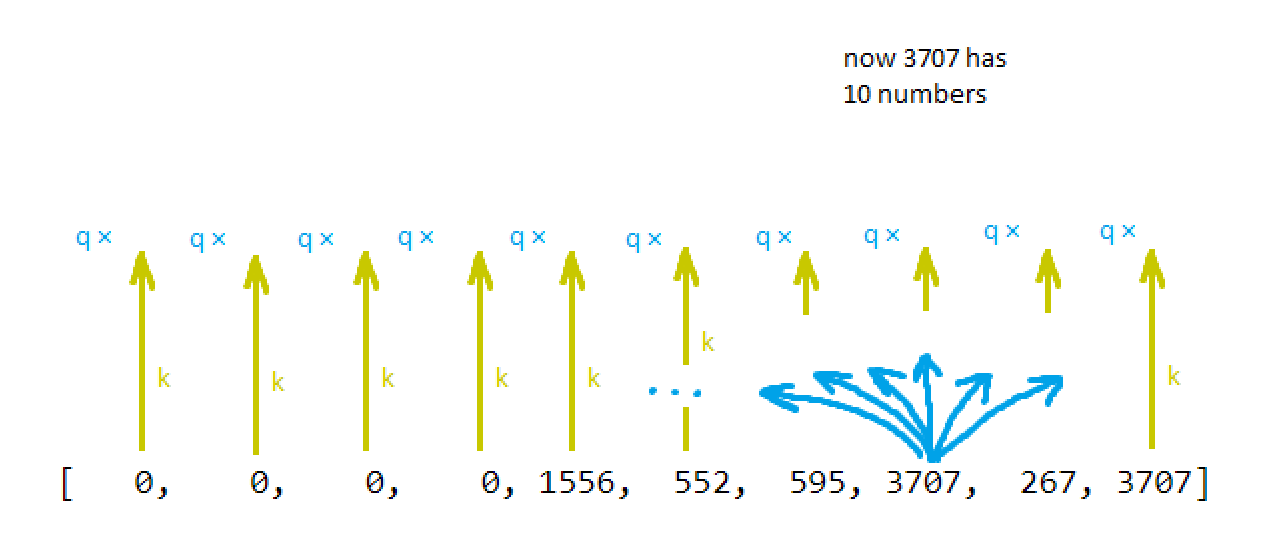

In [169]:
import math

scores = scores / math.sqrt(Q_each_head.size(-1))

In [171]:
print("look at mask for first user:")
print(mask[0])

look at mask for first user:
tensor([[[False, False, False, False,  True,  True,  True,  True,  True,  True],
         [False, False, False, False,  True,  True,  True,  True,  True,  True],
         [False, False, False, False,  True,  True,  True,  True,  True,  True],
         [False, False, False, False,  True,  True,  True,  True,  True,  True],
         [False, False, False, False,  True,  True,  True,  True,  True,  True],
         [False, False, False, False,  True,  True,  True,  True,  True,  True],
         [False, False, False, False,  True,  True,  True,  True,  True,  True],
         [False, False, False, False,  True,  True,  True,  True,  True,  True],
         [False, False, False, False,  True,  True,  True,  True,  True,  True],
         [False, False, False, False,  True,  True,  True,  True,  True,  True]]])


In [175]:
scores = scores.masked_fill(mask == 0, -1e9)
print("look at q * k^T results for first user (and first head) after applying mask:")
print(scores[0][0])

look at q * k^T results for first user (and first head) after applying mask:
tensor([[-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -3.8624e-01,
          1.8232e-01, -2.7510e-01,  4.0484e-01,  1.1977e-02,  2.2363e-01],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,  2.2407e-01,
          4.6016e-02,  3.9233e-01, -1.4759e-01,  4.3478e-01, -4.6642e-01],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -2.9412e-01,
          3.7792e-01, -4.3138e-01,  6.1771e-01, -4.1601e-03,  1.3266e-01],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -5.7382e-01,
         -6.0415e-01, -4.4366e-01,  1.7906e-01,  3.3365e-01,  9.1333e-02],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,  2.8659e-01,
         -3.3973e-02, -1.7891e-01, -3.5864e-01,  5.1863e-02,  1.2801e-01],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,  6.6538e-01,
         -3.3288e-01,  7.2621e-01,  2.5438e-02,  2.1390e-01,  1.2358e-01],
        [-1.0000e+09, -1.0000

In [177]:
import torch.nn.functional as F

p_attn = F.softmax(scores, dim=-1)

In [178]:
# dropout initialized inside tfblock0.multiheadedattention but used inside tfblock0.multiheadedattention.attention
p_attn = tfblock0.multiheadedattention.dropout(p_attn)

In [179]:
print(p_attn.shape, V_each_head.shape)

torch.Size([128, 4, 10, 10]) torch.Size([128, 4, 10, 64])


In [180]:
result_of_attention = torch.matmul(p_attn, V_each_head)

print(result_of_attention.shape)

torch.Size([128, 4, 10, 64])


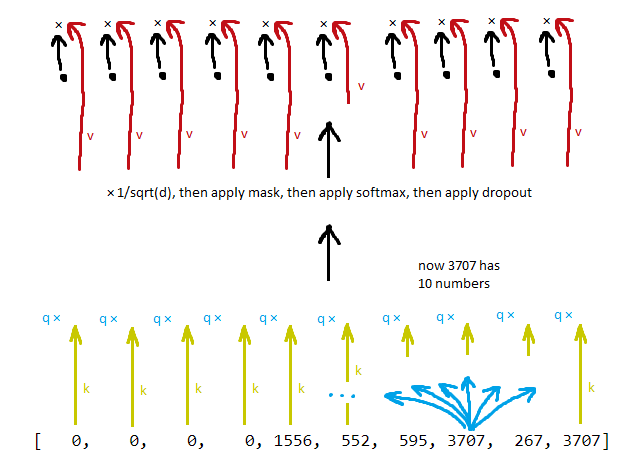

##### 4.2.3) swap heads dimension and sequence dimension again (return it as it was), concatenate 4 x 64 back to 256, run output linear layer

In [183]:
end_of_multihead_attention = result_of_attention.transpose(1, 2)

print(end_of_multihead_attention.shape)

torch.Size([128, 10, 4, 64])


In [184]:
# makes a copy of the tensor such that the order of its elements in memory is the same as if it 
# had been created from scratch with the same data.
end_of_multihead_attention = end_of_multihead_attention.contiguous()

print(end_of_multihead_attention.shape)

torch.Size([128, 10, 4, 64])


In [185]:
# concatenate different heads' outputs
end_of_multihead_attention = end_of_multihead_attention.view(
    batch_size, 
    sequence_len, 
    tfblock0.multiheadedattention.h * tfblock0.multiheadedattention.d_k
)

print(end_of_multihead_attention.shape)

torch.Size([128, 10, 256])


In [186]:
end_of_multihead_attention = tfblock0.multiheadedattention.output_linear(end_of_multihead_attention)

print(end_of_multihead_attention.shape)

torch.Size([128, 10, 256])


Multi-Head Attention done!

##### 4.3) end of sublayer 1 (Multi-Head Attention sublayer):

In [187]:
multihead_attention_output_with_dropout = tfblock0.dropout1(end_of_multihead_attention)

output_of_sublayer1 = multihead_attention_output_with_dropout + skip_connection

print(output_of_sublayer1.shape)

torch.Size([128, 10, 256])


sublayer 1 (Multi-Head Attention sublayer) done!

##### 5) going through this part:

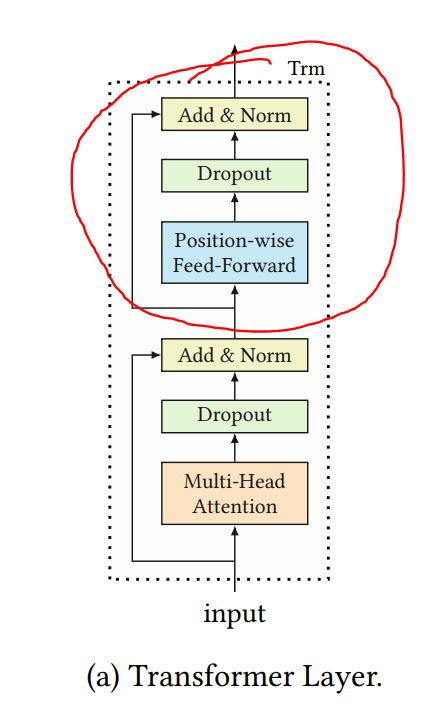

In [188]:
x = output_of_sublayer1

In [189]:
# nothing interesting here:
x_skip_connection2 = x
x = tfblock0.layernorm2(x)
x = tfblock0.feed_forward(x) # the only interesting thing is that it uses GELU instead of RELU
x = tfblock0.dropout2(x)
x += x_skip_connection2

##### 6) output of TransformerBlock:

In [190]:
tfblock0_output = tfblock0.dropout3(x)

##### 7) final output of bert4rec:

In [191]:
logits = model.out(tfblock0_output)

print(logits.shape)

torch.Size([128, 10, 3707])


# 6) train bert4rec and validate on test:

In [51]:
from bert4rec_modules_and_configs.trainers import trainer_factory

export_root = setup_train(args)

trainer = trainer_factory(args, model, train_torch_dataloader, val_torch_dataloader, test_torch_dataloader, export_root)

Folder created: C:\Users\atama\Documents\GitHub\bert4rec_ysda_seminar\seminar\experiments\test_2024-03-13_1
experiments\test_2024-03-13_1
experiments\test_2024-03-13_1\config.json

Namespace(mode='train', template=None, test_model_path=None, dataset_code='ml-1m', min_rating=0, min_uc=5, min_sc=0, split='leave_one_out', dataset_split_seed=98765, eval_set_size=500, prepared_data_path='prepared_dataset/dataset_for_bert4rec.pickle', dataloader_code='bert', dataloader_random_seed=0.0, train_batch_size=128, val_batch_size=128, test_batch_size=128, train_negative_sampler_code='random', train_negative_sample_size=0, train_negative_sampling_seed=0, test_negative_sampler_code='popular', test_negative_sample_size=100, test_negative_sampling_seed=98765, trainer_code='bert', device='cuda', num_gpu=1, device_idx='0', optimizer='Adam', lr=0.001, weight_decay=0, momentum=None, decay_step=25, gamma=1.0, num_epochs=100, log_period_as_iter=12800, metric_ks=[1, 5, 10, 20, 50, 100], best_metric='NDCG@10', 

In [52]:
# just train loop with crossentropy loss and some logging
trainer.train()

Val: N@1 0.007, N@5 0.028, N@10 0.045, R@1 0.007, R@5 0.050, R@10 0.102: 100%|██████████| 48/48 [00:04<00:00, 10.78it/s]
C:\Users\atama\anaconda3\envs\conda_bert4rec\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Update Best NDCG@10 Model at 1


Epoch 1, loss 7.827 : 100%|██████████| 48/48 [00:02<00:00, 18.45it/s]
Val: N@1 0.018, N@5 0.048, N@10 0.069, R@1 0.018, R@5 0.078, R@10 0.143: 100%|██████████| 48/48 [00:02<00:00, 21.89it/s]


Update Best NDCG@10 Model at 1


Epoch 2, loss 7.413 : 100%|██████████| 48/48 [00:02<00:00, 18.71it/s]
Val: N@1 0.022, N@5 0.057, N@10 0.079, R@1 0.022, R@5 0.092, R@10 0.161: 100%|██████████| 48/48 [00:02<00:00, 22.00it/s]


Update Best NDCG@10 Model at 2


Epoch 3, loss 7.198 : 100%|██████████| 48/48 [00:02<00:00, 18.75it/s] 
Val: N@1 0.032, N@5 0.080, N@10 0.111, R@1 0.032, R@5 0.130, R@10 0.225: 100%|██████████| 48/48 [00:02<00:00, 21.49it/s]


Update Best NDCG@10 Model at 3


Epoch 4, loss 6.976 : 100%|██████████| 48/48 [00:02<00:00, 18.43it/s]
Val: N@1 0.042, N@5 0.101, N@10 0.136, R@1 0.042, R@5 0.159, R@10 0.270: 100%|██████████| 48/48 [00:02<00:00, 21.43it/s]


Update Best NDCG@10 Model at 4


Epoch 5, loss 6.775 : 100%|██████████| 48/48 [00:02<00:00, 18.41it/s]  
Val: N@1 0.061, N@5 0.146, N@10 0.186, R@1 0.061, R@5 0.229, R@10 0.354: 100%|██████████| 48/48 [00:02<00:00, 21.47it/s]


Update Best NDCG@10 Model at 5


Epoch 6, loss 6.601 : 100%|██████████| 48/48 [00:02<00:00, 18.36it/s]
Val: N@1 0.082, N@5 0.176, N@10 0.218, R@1 0.082, R@5 0.266, R@10 0.398: 100%|██████████| 48/48 [00:02<00:00, 21.68it/s]


Update Best NDCG@10 Model at 6


Epoch 7, loss 6.437 : 100%|██████████| 48/48 [00:02<00:00, 18.18it/s]  
Val: N@1 0.095, N@5 0.202, N@10 0.248, R@1 0.095, R@5 0.305, R@10 0.447: 100%|██████████| 48/48 [00:02<00:00, 21.73it/s]


Update Best NDCG@10 Model at 7


Epoch 8, loss 6.306 : 100%|██████████| 48/48 [00:02<00:00, 18.62it/s]
Val: N@1 0.111, N@5 0.228, N@10 0.276, R@1 0.111, R@5 0.343, R@10 0.491: 100%|██████████| 48/48 [00:02<00:00, 21.68it/s]


Update Best NDCG@10 Model at 8


Epoch 9, loss 6.180 : 100%|██████████| 48/48 [00:02<00:00, 18.76it/s]  
Val: N@1 0.118, N@5 0.238, N@10 0.284, R@1 0.118, R@5 0.354, R@10 0.494: 100%|██████████| 48/48 [00:02<00:00, 21.67it/s]


Update Best NDCG@10 Model at 9


Epoch 10, loss 6.070 : 100%|██████████| 48/48 [00:02<00:00, 18.55it/s]
Val: N@1 0.128, N@5 0.251, N@10 0.299, R@1 0.128, R@5 0.368, R@10 0.516: 100%|██████████| 48/48 [00:02<00:00, 22.09it/s]


Update Best NDCG@10 Model at 10


Epoch 11, loss 6.002 : 100%|██████████| 48/48 [00:02<00:00, 18.86it/s] 
Val: N@1 0.145, N@5 0.274, N@10 0.318, R@1 0.145, R@5 0.397, R@10 0.535: 100%|██████████| 48/48 [00:02<00:00, 22.10it/s]


Update Best NDCG@10 Model at 11


Epoch 12, loss 5.920 : 100%|██████████| 48/48 [00:02<00:00, 18.49it/s]
Val: N@1 0.145, N@5 0.284, N@10 0.328, R@1 0.145, R@5 0.415, R@10 0.552: 100%|██████████| 48/48 [00:02<00:00, 21.37it/s]


Update Best NDCG@10 Model at 12


Epoch 13, loss 5.854 : 100%|██████████| 48/48 [00:02<00:00, 18.58it/s] 
Val: N@1 0.159, N@5 0.297, N@10 0.343, R@1 0.159, R@5 0.430, R@10 0.570: 100%|██████████| 48/48 [00:02<00:00, 21.68it/s]


Update Best NDCG@10 Model at 13


Epoch 14, loss 5.828 : 100%|██████████| 48/48 [00:02<00:00, 18.41it/s]
Val: N@1 0.169, N@5 0.307, N@10 0.352, R@1 0.169, R@5 0.437, R@10 0.575: 100%|██████████| 48/48 [00:02<00:00, 22.06it/s]


Update Best NDCG@10 Model at 14


Epoch 15, loss 5.752 : 100%|██████████| 48/48 [00:02<00:00, 18.57it/s] 
Val: N@1 0.167, N@5 0.311, N@10 0.356, R@1 0.167, R@5 0.446, R@10 0.584: 100%|██████████| 48/48 [00:02<00:00, 21.89it/s]


Update Best NDCG@10 Model at 15


Epoch 16, loss 5.709 : 100%|██████████| 48/48 [00:02<00:00, 18.28it/s]
Val: N@1 0.176, N@5 0.320, N@10 0.364, R@1 0.176, R@5 0.455, R@10 0.592: 100%|██████████| 48/48 [00:02<00:00, 21.43it/s]


Update Best NDCG@10 Model at 16


Epoch 17, loss 5.660 : 100%|██████████| 48/48 [00:02<00:00, 18.52it/s] 
Val: N@1 0.180, N@5 0.326, N@10 0.372, R@1 0.180, R@5 0.461, R@10 0.602: 100%|██████████| 48/48 [00:02<00:00, 22.06it/s]


Update Best NDCG@10 Model at 17


Epoch 18, loss 5.607 : 100%|██████████| 48/48 [00:02<00:00, 18.51it/s]
Val: N@1 0.187, N@5 0.330, N@10 0.374, R@1 0.187, R@5 0.462, R@10 0.600: 100%|██████████| 48/48 [00:02<00:00, 22.12it/s]


Update Best NDCG@10 Model at 18


Epoch 19, loss 5.577 : 100%|██████████| 48/48 [00:02<00:00, 18.71it/s]
Val: N@1 0.194, N@5 0.338, N@10 0.384, R@1 0.194, R@5 0.470, R@10 0.612: 100%|██████████| 48/48 [00:02<00:00, 22.14it/s]


Update Best NDCG@10 Model at 19


Epoch 20, loss 5.540 : 100%|██████████| 48/48 [00:02<00:00, 18.60it/s]
Val: N@1 0.193, N@5 0.346, N@10 0.390, R@1 0.193, R@5 0.489, R@10 0.625: 100%|██████████| 48/48 [00:02<00:00, 22.20it/s]


Update Best NDCG@10 Model at 20


Epoch 21, loss 5.511 : 100%|██████████| 48/48 [00:02<00:00, 17.94it/s]
Val: N@1 0.200, N@5 0.347, N@10 0.391, R@1 0.200, R@5 0.483, R@10 0.620: 100%|██████████| 48/48 [00:02<00:00, 21.35it/s]


Update Best NDCG@10 Model at 21


Epoch 22, loss 5.472 : 100%|██████████| 48/48 [00:02<00:00, 18.64it/s] 
Val: N@1 0.203, N@5 0.351, N@10 0.394, R@1 0.203, R@5 0.487, R@10 0.622: 100%|██████████| 48/48 [00:02<00:00, 22.04it/s]


Update Best NDCG@10 Model at 22


Epoch 23, loss 5.434 : 100%|██████████| 48/48 [00:02<00:00, 18.73it/s]
Val: N@1 0.207, N@5 0.361, N@10 0.405, R@1 0.207, R@5 0.503, R@10 0.639: 100%|██████████| 48/48 [00:02<00:00, 21.49it/s]


Update Best NDCG@10 Model at 23


Epoch 24, loss 5.413 : 100%|██████████| 48/48 [00:02<00:00, 18.63it/s] 
Val: N@1 0.206, N@5 0.356, N@10 0.401, R@1 0.206, R@5 0.495, R@10 0.636: 100%|██████████| 48/48 [00:02<00:00, 21.53it/s]
Epoch 25, loss 5.393 : 100%|██████████| 48/48 [00:02<00:00, 18.60it/s]
Val: N@1 0.215, N@5 0.368, N@10 0.410, R@1 0.215, R@5 0.507, R@10 0.637: 100%|██████████| 48/48 [00:02<00:00, 21.86it/s]


Update Best NDCG@10 Model at 25


Epoch 26, loss 5.369 : 100%|██████████| 48/48 [00:02<00:00, 18.78it/s] 
Val: N@1 0.217, N@5 0.365, N@10 0.409, R@1 0.217, R@5 0.499, R@10 0.634: 100%|██████████| 48/48 [00:02<00:00, 21.41it/s]
Epoch 27, loss 5.365 : 100%|██████████| 48/48 [00:02<00:00, 18.40it/s]
Val: N@1 0.217, N@5 0.367, N@10 0.409, R@1 0.217, R@5 0.507, R@10 0.637: 100%|██████████| 48/48 [00:02<00:00, 21.59it/s]
Epoch 28, loss 5.334 : 100%|██████████| 48/48 [00:02<00:00, 18.62it/s] 
Val: N@1 0.220, N@5 0.373, N@10 0.415, R@1 0.220, R@5 0.514, R@10 0.643: 100%|██████████| 48/48 [00:02<00:00, 21.94it/s]


Update Best NDCG@10 Model at 28


Epoch 29, loss 5.283 : 100%|██████████| 48/48 [00:02<00:00, 18.34it/s]
Val: N@1 0.230, N@5 0.377, N@10 0.421, R@1 0.230, R@5 0.513, R@10 0.646: 100%|██████████| 48/48 [00:02<00:00, 21.77it/s]


Update Best NDCG@10 Model at 29


Epoch 30, loss 5.275 : 100%|██████████| 48/48 [00:02<00:00, 18.55it/s] 
Val: N@1 0.225, N@5 0.379, N@10 0.421, R@1 0.225, R@5 0.521, R@10 0.652: 100%|██████████| 48/48 [00:02<00:00, 21.91it/s]


Update Best NDCG@10 Model at 30


Epoch 31, loss 5.257 : 100%|██████████| 48/48 [00:02<00:00, 18.61it/s]
Val: N@1 0.227, N@5 0.382, N@10 0.423, R@1 0.227, R@5 0.523, R@10 0.648: 100%|██████████| 48/48 [00:02<00:00, 22.25it/s]


Update Best NDCG@10 Model at 31


Epoch 32, loss 5.241 : 100%|██████████| 48/48 [00:02<00:00, 18.57it/s] 
Val: N@1 0.231, N@5 0.385, N@10 0.424, R@1 0.231, R@5 0.526, R@10 0.649: 100%|██████████| 48/48 [00:02<00:00, 22.13it/s]


Update Best NDCG@10 Model at 32


Epoch 33, loss 5.242 : 100%|██████████| 48/48 [00:02<00:00, 18.60it/s]
Val: N@1 0.234, N@5 0.391, N@10 0.433, R@1 0.234, R@5 0.536, R@10 0.666: 100%|██████████| 48/48 [00:02<00:00, 22.29it/s]


Update Best NDCG@10 Model at 33


Epoch 34, loss 5.218 : 100%|██████████| 48/48 [00:02<00:00, 18.74it/s] 
Val: N@1 0.234, N@5 0.387, N@10 0.431, R@1 0.234, R@5 0.526, R@10 0.662: 100%|██████████| 48/48 [00:02<00:00, 21.92it/s]
Epoch 35, loss 5.181 : 100%|██████████| 48/48 [00:02<00:00, 18.56it/s]
Val: N@1 0.235, N@5 0.391, N@10 0.433, R@1 0.235, R@5 0.535, R@10 0.663: 100%|██████████| 48/48 [00:02<00:00, 21.88it/s]
Epoch 36, loss 5.175 : 100%|██████████| 48/48 [00:02<00:00, 18.71it/s]
Val: N@1 0.230, N@5 0.384, N@10 0.427, R@1 0.230, R@5 0.523, R@10 0.655: 100%|██████████| 48/48 [00:02<00:00, 21.86it/s]
Epoch 37, loss 5.131 : 100%|██████████| 48/48 [00:02<00:00, 18.48it/s]
Val: N@1 0.236, N@5 0.388, N@10 0.428, R@1 0.236, R@5 0.526, R@10 0.650: 100%|██████████| 48/48 [00:02<00:00, 21.59it/s]
Epoch 38, loss 5.142 : 100%|██████████| 48/48 [00:02<00:00, 18.48it/s]
Val: N@1 0.249, N@5 0.398, N@10 0.439, R@1 0.249, R@5 0.535, R@10 0.661: 100%|██████████| 48/48 [00:02<00:00, 21.40it/s]


Update Best NDCG@10 Model at 38


Epoch 39, loss 5.135 : 100%|██████████| 48/48 [00:02<00:00, 18.74it/s]
Val: N@1 0.250, N@5 0.404, N@10 0.443, R@1 0.250, R@5 0.546, R@10 0.666: 100%|██████████| 48/48 [00:02<00:00, 22.38it/s]


Update Best NDCG@10 Model at 39


Epoch 40, loss 5.114 : 100%|██████████| 48/48 [00:02<00:00, 18.54it/s]
Val: N@1 0.248, N@5 0.402, N@10 0.442, R@1 0.248, R@5 0.541, R@10 0.667: 100%|██████████| 48/48 [00:02<00:00, 22.09it/s]
Epoch 41, loss 5.095 : 100%|██████████| 48/48 [00:02<00:00, 18.55it/s] 
Val: N@1 0.248, N@5 0.404, N@10 0.445, R@1 0.248, R@5 0.547, R@10 0.672: 100%|██████████| 48/48 [00:02<00:00, 22.08it/s]


Update Best NDCG@10 Model at 41


Epoch 42, loss 5.091 : 100%|██████████| 48/48 [00:02<00:00, 18.39it/s]
Val: N@1 0.246, N@5 0.402, N@10 0.445, R@1 0.246, R@5 0.544, R@10 0.674: 100%|██████████| 48/48 [00:02<00:00, 20.25it/s]
Epoch 43, loss 5.083 : 100%|██████████| 48/48 [00:02<00:00, 18.04it/s] 
Val: N@1 0.247, N@5 0.401, N@10 0.443, R@1 0.247, R@5 0.538, R@10 0.668: 100%|██████████| 48/48 [00:02<00:00, 20.08it/s]
Epoch 44, loss 5.076 : 100%|██████████| 48/48 [00:02<00:00, 18.44it/s]
Val: N@1 0.230, N@5 0.390, N@10 0.433, R@1 0.230, R@5 0.535, R@10 0.665: 100%|██████████| 48/48 [00:02<00:00, 20.36it/s]
Epoch 45, loss 5.063 : 100%|██████████| 48/48 [00:02<00:00, 18.52it/s] 
Val: N@1 0.242, N@5 0.399, N@10 0.440, R@1 0.242, R@5 0.542, R@10 0.668: 100%|██████████| 48/48 [00:02<00:00, 20.36it/s]
Epoch 46, loss 5.048 : 100%|██████████| 48/48 [00:02<00:00, 18.37it/s]
Val: N@1 0.250, N@5 0.404, N@10 0.446, R@1 0.250, R@5 0.543, R@10 0.674: 100%|██████████| 48/48 [00:02<00:00, 20.37it/s]


Update Best NDCG@10 Model at 46


Epoch 47, loss 5.033 : 100%|██████████| 48/48 [00:02<00:00, 18.30it/s] 
Val: N@1 0.248, N@5 0.406, N@10 0.446, R@1 0.248, R@5 0.550, R@10 0.674: 100%|██████████| 48/48 [00:02<00:00, 22.17it/s]
Epoch 48, loss 5.018 : 100%|██████████| 48/48 [00:02<00:00, 18.95it/s]
Val: N@1 0.253, N@5 0.412, N@10 0.452, R@1 0.253, R@5 0.553, R@10 0.678: 100%|██████████| 48/48 [00:02<00:00, 22.29it/s]


Update Best NDCG@10 Model at 48


Epoch 49, loss 4.998 : 100%|██████████| 48/48 [00:02<00:00, 18.75it/s] 
Val: N@1 0.252, N@5 0.408, N@10 0.449, R@1 0.252, R@5 0.549, R@10 0.674: 100%|██████████| 48/48 [00:02<00:00, 21.97it/s]
Epoch 50, loss 4.999 : 100%|██████████| 48/48 [00:02<00:00, 18.63it/s]
Val: N@1 0.247, N@5 0.401, N@10 0.442, R@1 0.247, R@5 0.542, R@10 0.667: 100%|██████████| 48/48 [00:02<00:00, 22.09it/s]
Epoch 51, loss 4.974 : 100%|██████████| 48/48 [00:02<00:00, 18.61it/s] 
Val: N@1 0.254, N@5 0.411, N@10 0.450, R@1 0.254, R@5 0.555, R@10 0.674: 100%|██████████| 48/48 [00:02<00:00, 22.39it/s]
Epoch 52, loss 4.985 : 100%|██████████| 48/48 [00:02<00:00, 18.43it/s]
Val: N@1 0.257, N@5 0.413, N@10 0.454, R@1 0.257, R@5 0.554, R@10 0.681: 100%|██████████| 48/48 [00:02<00:00, 22.17it/s]


Update Best NDCG@10 Model at 52


Logging to Tensorboard: 100%|██████████| 48/48 [00:02<00:00, 18.57it/s]
Val: N@1 0.257, N@5 0.414, N@10 0.454, R@1 0.257, R@5 0.556, R@10 0.679: 100%|██████████| 48/48 [00:02<00:00, 22.09it/s]
Epoch 54, loss 4.978 : 100%|██████████| 48/48 [00:02<00:00, 18.84it/s]
Val: N@1 0.249, N@5 0.407, N@10 0.447, R@1 0.249, R@5 0.549, R@10 0.673: 100%|██████████| 48/48 [00:02<00:00, 22.35it/s]
Epoch 55, loss 4.962 : 100%|██████████| 48/48 [00:02<00:00, 18.88it/s]
Val: N@1 0.261, N@5 0.416, N@10 0.455, R@1 0.261, R@5 0.557, R@10 0.678: 100%|██████████| 48/48 [00:02<00:00, 22.16it/s]


Update Best NDCG@10 Model at 55


Epoch 56, loss 4.939 : 100%|██████████| 48/48 [00:02<00:00, 18.66it/s]
Val: N@1 0.261, N@5 0.416, N@10 0.454, R@1 0.261, R@5 0.559, R@10 0.676: 100%|██████████| 48/48 [00:02<00:00, 22.06it/s]
Epoch 57, loss 4.942 : 100%|██████████| 48/48 [00:02<00:00, 18.60it/s]
Val: N@1 0.261, N@5 0.413, N@10 0.452, R@1 0.261, R@5 0.551, R@10 0.670: 100%|██████████| 48/48 [00:02<00:00, 22.23it/s]
Epoch 58, loss 4.938 : 100%|██████████| 48/48 [00:02<00:00, 18.62it/s] 
Val: N@1 0.255, N@5 0.412, N@10 0.453, R@1 0.255, R@5 0.553, R@10 0.679: 100%|██████████| 48/48 [00:02<00:00, 22.25it/s]
Epoch 59, loss 4.918 : 100%|██████████| 48/48 [00:02<00:00, 18.70it/s]
Val: N@1 0.253, N@5 0.415, N@10 0.453, R@1 0.253, R@5 0.561, R@10 0.679: 100%|██████████| 48/48 [00:02<00:00, 22.11it/s]
Epoch 60, loss 4.925 : 100%|██████████| 48/48 [00:02<00:00, 18.74it/s] 
Val: N@1 0.258, N@5 0.413, N@10 0.455, R@1 0.258, R@5 0.555, R@10 0.682: 100%|██████████| 48/48 [00:02<00:00, 22.02it/s]
Epoch 61, loss 4.920 : 100%|██████████

Update Best NDCG@10 Model at 62


Epoch 63, loss 4.910 : 100%|██████████| 48/48 [00:02<00:00, 18.57it/s]
Val: N@1 0.264, N@5 0.418, N@10 0.458, R@1 0.264, R@5 0.559, R@10 0.681: 100%|██████████| 48/48 [00:02<00:00, 22.07it/s]
Epoch 64, loss 4.884 : 100%|██████████| 48/48 [00:02<00:00, 18.51it/s] 
Val: N@1 0.264, N@5 0.421, N@10 0.461, R@1 0.264, R@5 0.562, R@10 0.687: 100%|██████████| 48/48 [00:02<00:00, 22.27it/s]
Epoch 65, loss 4.879 : 100%|██████████| 48/48 [00:02<00:00, 18.67it/s]
Val: N@1 0.260, N@5 0.419, N@10 0.457, R@1 0.260, R@5 0.563, R@10 0.681: 100%|██████████| 48/48 [00:02<00:00, 22.11it/s]
Epoch 66, loss 4.874 : 100%|██████████| 48/48 [00:02<00:00, 18.50it/s] 
Val: N@1 0.264, N@5 0.421, N@10 0.461, R@1 0.264, R@5 0.564, R@10 0.687: 100%|██████████| 48/48 [00:02<00:00, 22.39it/s]
Epoch 67, loss 4.871 : 100%|██████████| 48/48 [00:02<00:00, 18.50it/s]
Val: N@1 0.265, N@5 0.423, N@10 0.463, R@1 0.265, R@5 0.566, R@10 0.689: 100%|██████████| 48/48 [00:02<00:00, 21.95it/s]
Epoch 68, loss 4.862 : 100%|██████████

Update Best NDCG@10 Model at 69


Epoch 70, loss 4.845 : 100%|██████████| 48/48 [00:02<00:00, 18.80it/s] 
Val: N@1 0.270, N@5 0.426, N@10 0.467, R@1 0.270, R@5 0.569, R@10 0.693: 100%|██████████| 48/48 [00:02<00:00, 22.22it/s]


Update Best NDCG@10 Model at 70


Epoch 71, loss 4.854 : 100%|██████████| 48/48 [00:02<00:00, 18.48it/s]
Val: N@1 0.267, N@5 0.420, N@10 0.462, R@1 0.267, R@5 0.557, R@10 0.686: 100%|██████████| 48/48 [00:02<00:00, 21.97it/s]
Epoch 72, loss 4.821 : 100%|██████████| 48/48 [00:02<00:00, 18.58it/s]
Val: N@1 0.263, N@5 0.422, N@10 0.462, R@1 0.263, R@5 0.566, R@10 0.687: 100%|██████████| 48/48 [00:02<00:00, 22.12it/s]
Epoch 73, loss 4.829 : 100%|██████████| 48/48 [00:02<00:00, 18.60it/s]
Val: N@1 0.260, N@5 0.419, N@10 0.457, R@1 0.260, R@5 0.565, R@10 0.683: 100%|██████████| 48/48 [00:02<00:00, 22.18it/s]
Epoch 74, loss 4.835 : 100%|██████████| 48/48 [00:02<00:00, 18.65it/s]
Val: N@1 0.268, N@5 0.422, N@10 0.460, R@1 0.268, R@5 0.564, R@10 0.682: 100%|██████████| 48/48 [00:02<00:00, 21.94it/s]
Epoch 75, loss 4.823 : 100%|██████████| 48/48 [00:02<00:00, 18.61it/s]
Val: N@1 0.266, N@5 0.421, N@10 0.462, R@1 0.266, R@5 0.560, R@10 0.685: 100%|██████████| 48/48 [00:02<00:00, 22.22it/s]
Epoch 76, loss 4.824 : 100%|██████████| 

Update Best NDCG@10 Model at 98


Epoch 99, loss 4.689 : 100%|██████████| 48/48 [00:02<00:00, 18.83it/s]
Val: N@1 0.265, N@5 0.422, N@10 0.459, R@1 0.265, R@5 0.564, R@10 0.679: 100%|██████████| 48/48 [00:02<00:00, 21.66it/s]
Epoch 100, loss 4.687 : 100%|██████████| 48/48 [00:02<00:00, 18.78it/s]
Val: N@1 0.270, N@5 0.425, N@10 0.463, R@1 0.270, R@5 0.567, R@10 0.685: 100%|██████████| 48/48 [00:02<00:00, 21.73it/s]


In [53]:
# run on test_torch_dataloader and compute metrics
trainer.test()

Test best model with test set!


Val: N@1 0.214, N@5 0.359, N@10 0.400, R@1 0.214, R@5 0.489, R@10 0.618: 100%|██████████| 48/48 [00:02<00:00, 17.89it/s]

{'Recall@100': 0.9982096354166666, 'NDCG@100': 0.4778992434342702, 'Recall@50': 0.8823784726361433, 'NDCG@50': 0.4590541211267312, 'Recall@20': 0.7296006952722868, 'NDCG@20': 0.42861032610138255, 'Recall@10': 0.6177300351361433, 'NDCG@10': 0.4004720418403546, 'Recall@5': 0.48871527798473835, 'NDCG@5': 0.35864060185849667, 'Recall@1': 0.21435546875, 'NDCG@1': 0.21435546875}


# 7) validate model by the same algorithm which was used in baselines:

In [54]:
best_model = torch.load(os.path.join(export_root, 'models', 'best_acc_model.pth')).get('model_state_dict')

In [55]:
model.load_state_dict(best_model)

<All keys matched successfully>

In [56]:
model.eval()

BERTModel(
  (bert): BERT(
    (embedding): BERTEmbedding(
      (token): TokenEmbedding(3708, 256, padding_idx=0)
      (position): PositionalEmbedding(
        (pe): Embedding(100, 256)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer_blocks): ModuleList(
      (0): TransformerBlock(
        (layernorm1): LayerNorm()
        (multiheadedattention): MultiHeadedAttention(
          (linear_layers): ModuleList(
            (0): Linear(in_features=256, out_features=256, bias=True)
            (1): Linear(in_features=256, out_features=256, bias=True)
            (2): Linear(in_features=256, out_features=256, bias=True)
          )
          (output_linear): Linear(in_features=256, out_features=256, bias=True)
          (attention): Attention()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (layernorm2): LayerNorm()
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in

In [57]:
from tqdm import tqdm

# make predicts for mask_token on test data:
scores_for_mask_token_for_each_batch = []

with torch.no_grad():
    tqdm_dataloader = tqdm(test_torch_dataloader)
    
    for batch_idx, batch in enumerate(tqdm_dataloader):
        batch = [x.to('cuda') for x in batch]
        
        scores = model(batch[0])
        scores_for_mask_token = scores[:, -1, :]
        
        scores_for_mask_token_for_each_batch.append(scores_for_mask_token.cpu())

100%|██████████| 48/48 [00:01<00:00, 41.88it/s]


In [58]:
scores_for_mask_token = torch.cat(scores_for_mask_token_for_each_batch, dim=0)

scores_for_mask_token.shape

torch.Size([6040, 3707])

In [59]:
user_to_scores_of_items = dict()

for user_ix, scores in enumerate(scores_for_mask_token):
    user_to_scores_of_items[user_ix] = dict()
    
    for item_ix, score in enumerate(scores):
        user_to_scores_of_items[user_ix][item_ix] = score.item()

In [60]:
# track user ix 0 (original user id 1)
print(
    user_to_scores_of_items[0][49], # positive from train
    user_to_scores_of_items[0][50], # positive from train
    user_to_scores_of_items[0][51], # not seen in train (but should - it's from val data), but in full data it's a positive
    user_to_scores_of_items[0][52], # not seen in train, but in full data it's a positive
    user_to_scores_of_items[0][53], # not seen in train (didnt exist in train + val + test)
    user_to_scores_of_items[0][54], # not seen in train (didnt exist in train + val + test)
)

9.1160249710083 8.838234901428223 9.078511238098145 10.268392562866211 2.6223578453063965 2.0956482887268066


looks nice

In [61]:
calculate_grouped_ndcg_for_bert4rec_output(neg_sampled_test, user_to_scores_of_items, 10)

0.4000863977446544

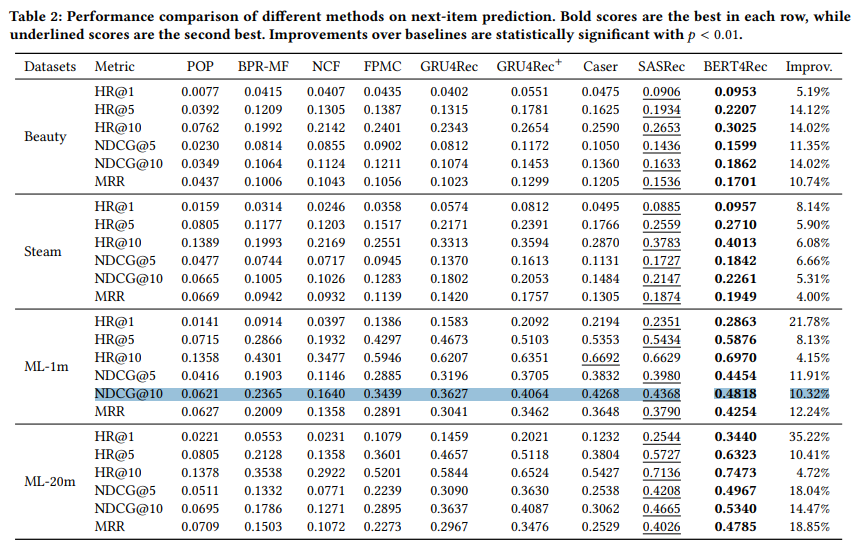

strange things in this implementation:
1) we apply mask only in 80% of cases. in other cases there is something weird.
2) "padding token" value is the same as "first seen item in dataset token" value (0).
3) in contrast to paper - we dont add 10% of traind dataset with "only last item masked"
4) we dont return validation-holdout item to train when we run "test" part
5) output layer without nonlinearity (without GELU)